In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
train_1 = pd.read_csv('ACT1_train_50_corr_red.csv')

In [8]:
train_1.head(5)

,Unnamed: 0,Act,D_1114,D_1115,D_1116,D_1117,D_1215,D_1217,D_1286,D_1486,...,D_519,D_520,D_521,D_5523,D_5524,D_5526,D_5527,D_7349,D_834,D_835
0,0,6.0179,0,0,0,0,5,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4.3003,0,0,0,0,3,2,0,0,...,0,0,0,1,1,0,1,0,0,0
2,2,5.2697,0,0,0,0,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,6.1797,0,0,0,0,5,5,0,0,...,0,0,0,4,4,2,3,1,0,0
4,4,4.3003,0,0,0,0,4,2,3,0,...,0,0,0,3,0,0,0,2,0,0


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
y = train_1['Act'].values
train_1 = train_1.drop(['Act', 'Unnamed: 0'], axis = 1)
x = train_1.values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)


In [10]:
print(np.shape(Y_train), np.shape(X_train), np.shape(Y_test), np.shape(X_test))
Y_train = np.reshape(Y_train,(len(Y_train),1))
Y_test = np.reshape(Y_test,(len(Y_test),1))


(22344,) (22344, 49) (7449,) (7449, 49)


In [11]:
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

In [12]:
from keras import backend as K
#Keras R_2 function
R_2 = []
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


In [13]:
from sklearn.metrics import make_scorer
#Keras MAPE function
MAPE = []
def mean_ape(y_true, y_pred):
    return K.mean(K.abs((y_true-y_pred)/y_true))*100
#Scikit learn mape function
def mean_apes(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
mape_func = make_scorer(mean_apes)

In [14]:
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [15]:
def build_model(learn_rate):
    model = keras.models.Sequential();
    model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 49));
    model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
    model.add(keras.layers.core.Dense(1, activation = 'relu'));
    adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
    model.compile(optimizer=adam,loss='mean_squared_error')
    return model

In [16]:
regressor = KerasRegressor(build_fn=build_model)

In [20]:
from sklearn.model_selection import RandomizedSearchCV
parameters ={'batch_size':[50,100,200],
            'nb_epoch':[50,150,250],
            'learn_rate':[0.01,0.1]}
random_search= RandomizedSearchCV(estimator=regressor, param_distributions=parameters,n_jobs=-1,cv=5, scoring = mape_func, n_iter=18)

In [21]:
random_search.fit(x, y)

C:\Users\willi\Anaconda3\envs\data-x\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/1
37241/37241 [==============================] - 1s 15us/step - loss: 16.0219


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000013BF8AF0198>,
          fit_params=None, iid='warn', n_iter=18, n_jobs=-1,
          param_distributions={'batch_size': [50, 100, 200], 'nb_epoch': [50, 150, 250], 'learn_rate': [0.01, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(mean_apes),
          verbose=0)

In [29]:
random_search.cv_results_['mean_test_score']

array([ 8.71214022,  8.55861807,  8.1095579 , 25.84802527, 26.84362985,
        9.72622251,  9.40235389,  8.78648116,  8.70996708, 45.97544622,
       81.62944692, 45.11416534, 10.38387814, 11.03150694, 11.01449922,
       46.66801114, 45.54370943, 63.79509402])

In [38]:
gridsearchdf = pd.DataFrame(random_search.cv_results_)
results = gridsearchdf[['mean_test_score','param_nb_epoch','param_learn_rate','param_batch_size']].sort_values('mean_test_score')
results

,mean_test_score,param_nb_epoch,param_learn_rate,param_batch_size
2,8.109558,250,0.01,50
1,8.558618,150,0.01,50
8,8.709967,250,0.01,100
0,8.712140,50,0.01,50
7,8.786481,150,0.01,100
6,9.402354,50,0.01,100
5,9.726223,250,0.1,50
12,10.383878,50,0.01,200
14,11.014499,250,0.01,200
13,11.031507,150,0.01,200


In [ ]:
#Manual Tuning Below

In [39]:
#Keras model
for epochs in [250]:
    for batch in [50]:
        K.clear_session()
        model = keras.models.Sequential();
        model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 49));
        model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
        model.add(keras.layers.core.Dense(1, activation = 'relu'));
        adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
        model.compile(loss="mean_squared_error", optimizer=adam, metrics = [coeff_determination, mean_ape,'mae']);
        print(model.summary(), 'Epochs = ', epochs, 'Batch =', batch);
        history = model.fit(X_train, Y_train, epochs = epochs, batch_size= batch, verbose = 1);
        #print(model.evaluate(X_val, Y_val,verbose=False)[1], )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                2000      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_________________________________________________________________
None Epochs =  250 Batch = 50
Epoch 1/250
22344/22344 [==============================] - 0s 22us/step - loss: 0.7814 - coeff_determination: -1.1438 - mean_ape: 13.0534 - mean_absolute_error: 0.6250
Epoch 2/250
22344/22344 [==============================] - 0s 15us/step - loss: 0.3065 - coeff_determination: 0.1961 - mean_ape: 8.2864 - mean_absolute_error: 0.4063
Epoch 3/250
22344/22344 [===============

22344/22344 [==============================] - 0s 13us/step - loss: 0.1968 - coeff_determination: 0.4775 - mean_ape: 6.2162 - mean_absolute_error: 0.3075
Epoch 46/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1945 - coeff_determination: 0.4881 - mean_ape: 6.1956 - mean_absolute_error: 0.3063
Epoch 47/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1934 - coeff_determination: 0.4861 - mean_ape: 6.2001 - mean_absolute_error: 0.3063
Epoch 48/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1942 - coeff_determination: 0.4749 - mean_ape: 6.2045 - mean_absolute_error: 0.3067
Epoch 49/250
22344/22344 [==============================] - 0s 15us/step - loss: 0.1925 - coeff_determination: 0.4863 - mean_ape: 6.1818 - mean_absolute_error: 0.3052
Epoch 50/250
22344/22344 [==============================] - 0s 15us/step - loss: 0.1919 - coeff_determination: 0.4850 - mean_ape: 6.1593 - mean_absolute_error: 0.3043 0s - loss: 

22344/22344 [==============================] - 0s 13us/step - loss: 0.1816 - coeff_determination: 0.5103 - mean_ape: 6.0164 - mean_absolute_error: 0.2970
Epoch 94/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1813 - coeff_determination: 0.5164 - mean_ape: 6.0359 - mean_absolute_error: 0.2978
Epoch 95/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1810 - coeff_determination: 0.5163 - mean_ape: 6.0390 - mean_absolute_error: 0.2980
Epoch 96/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1807 - coeff_determination: 0.5205 - mean_ape: 5.9913 - mean_absolute_error: 0.2957
Epoch 97/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1818 - coeff_determination: 0.5137 - mean_ape: 6.0521 - mean_absolute_error: 0.2988
Epoch 98/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1802 - coeff_determination: 0.5241 - mean_ape: 6.0153 - mean_absolute_error: 0.2970
Epoch 99/25

22344/22344 [==============================] - 0s 13us/step - loss: 0.1756 - coeff_determination: 0.5294 - mean_ape: 5.9352 - mean_absolute_error: 0.2926
Epoch 142/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1782 - coeff_determination: 0.5271 - mean_ape: 5.9808 - mean_absolute_error: 0.2952
Epoch 143/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1766 - coeff_determination: 0.5364 - mean_ape: 5.9376 - mean_absolute_error: 0.2931
Epoch 144/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1758 - coeff_determination: 0.5313 - mean_ape: 5.9504 - mean_absolute_error: 0.2935
Epoch 145/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1756 - coeff_determination: 0.5302 - mean_ape: 5.9245 - mean_absolute_error: 0.2923
Epoch 146/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1784 - coeff_determination: 0.5277 - mean_ape: 6.0209 - mean_absolute_error: 0.2971
Epoch 

22344/22344 [==============================] - 0s 13us/step - loss: 0.1744 - coeff_determination: 0.5352 - mean_ape: 5.9120 - mean_absolute_error: 0.2915
Epoch 190/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1768 - coeff_determination: 0.5318 - mean_ape: 5.9450 - mean_absolute_error: 0.2934
Epoch 191/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1746 - coeff_determination: 0.5339 - mean_ape: 5.9400 - mean_absolute_error: 0.2929
Epoch 192/250
22344/22344 [==============================] - 0s 12us/step - loss: 0.1744 - coeff_determination: 0.5340 - mean_ape: 5.9231 - mean_absolute_error: 0.2921
Epoch 193/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1746 - coeff_determination: 0.5378 - mean_ape: 5.9141 - mean_absolute_error: 0.2918
Epoch 194/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1735 - coeff_determination: 0.5376 - mean_ape: 5.8867 - mean_absolute_error: 0.2903
Epoch 

22344/22344 [==============================] - 0s 13us/step - loss: 0.1718 - coeff_determination: 0.5471 - mean_ape: 5.8914 - mean_absolute_error: 0.2904
Epoch 237/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1725 - coeff_determination: 0.5407 - mean_ape: 5.8843 - mean_absolute_error: 0.2903
Epoch 238/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1750 - coeff_determination: 0.5341 - mean_ape: 5.9196 - mean_absolute_error: 0.2921
Epoch 239/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1724 - coeff_determination: 0.5368 - mean_ape: 5.8913 - mean_absolute_error: 0.2906
Epoch 240/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1722 - coeff_determination: 0.5391 - mean_ape: 5.8938 - mean_absolute_error: 0.2905
Epoch 241/250
22344/22344 [==============================] - 0s 13us/step - loss: 0.1717 - coeff_determination: 0.5450 - mean_ape: 5.8842 - mean_absolute_error: 0.2901
Epoch 

In [40]:
print(history.history.keys())

dict_keys(['loss', 'coeff_determination', 'mean_ape', 'mean_absolute_error'])


In [41]:
print(model.evaluate(X_val, Y_val,verbose=False))
print(model.evaluate(X_test, Y_test,verbose=False))

[0.22932559317408008, 0.358630014221343, 6.738444533691243, 0.3293896548281935]
[0.23263345323307977, 0.3485950086881433, 6.80854344825678, 0.3328472081127223]


In [42]:
Y_predict = model.predict(X_test)
np.mean(np.abs((Y_predict-Y_test)/Y_test))*100

6.808545120199846

In [43]:
np.mean(np.abs((Y_predict-Y_test)))

0.33284727562986166

In [84]:
mean_apes(Y_predict,Y_test)

6.8082696116784565

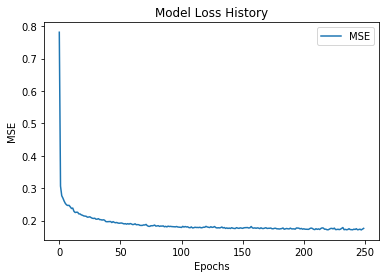

In [45]:
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_ape'])
plt.title('Model Loss History')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['MSE'])


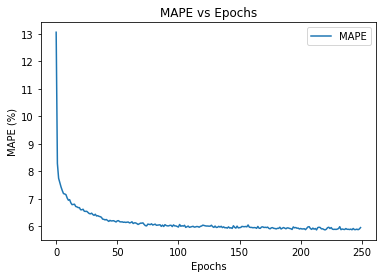

In [46]:
plt.plot(history.history['mean_ape'])
#plt.plot(history.history['mean_ape'])
plt.title('MAPE vs Epochs')
plt.ylabel('MAPE (%)')
plt.xlabel('Epochs')
plt.legend(['MAPE'])


9.298479446013058


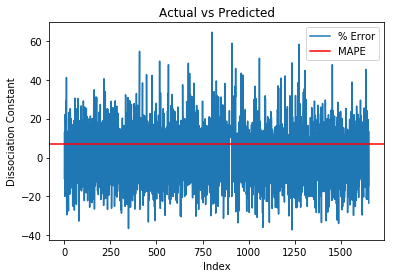

In [93]:
comparison = np.ravel((Y_predict-Y_test)/Y_test*100)
abs_comparison = np.abs(comparison)
mask = np.where(abs_comparison>10)
plt.plot(range(np.shape(mask)[1]), comparison[mask])
plt.axhline(y=mean_apes(Y_predict,Y_test), color='r', linestyle='-')
plt.title('Actual vs Predicted')
plt.ylabel('Dissociation Constant')
plt.xlabel('Index')
plt.legend(['% Error', 'MAPE'])
print(comparison.std())

In [88]:
import seaborn as sns
hyp = pd.DataFrame()

In [89]:
hyp['MAPE'] = random_search.cv_results_['mean_test_score']
hyp['index'] = hyp.index + 1
hyp

,MAPE,index
0,8.712140,1
1,8.558618,2
2,8.109558,3
3,25.848025,4
4,26.843630,5
5,9.726223,6
6,9.402354,7
7,8.786481,8
8,8.709967,9
9,45.975446,10


C:\Users\willi\Anaconda3\envs\data-x\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\willi\Anaconda3\envs\data-x\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


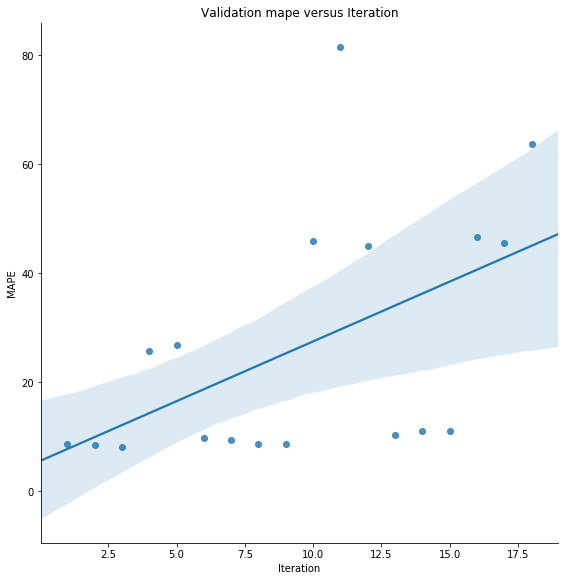

In [90]:
# MAPE Score
#hyp.sort_values('mean_test_score', inplace = True)

# Plot of scores over the course of searching
#sns.lmplot(hyp.index.values, hyp['MAPE'], data = hyp, hue = 'data', size = 8);
sns.lmplot('index', 'MAPE',data=hyp, size = 8);
#plt.scatter(hyp.index, hyp['MAPE'],  marker = '*', s = 400, c = 'blue')

plt.xlabel('Iteration'); plt.ylabel('MAPE'); plt.title("Validation mape versus Iteration");